In [10]:
import torch

import torch.nn as nn

import numpy as np

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

from sklearn.decomposition import PCA

In [11]:
# Step 1: Tokenize corpus into words

corpus = "deep learning is fun and deep learning is powerful"

words = corpus.split()

In [12]:
# Step 2: Build vocabulary

vocab = sorted(set(words))

vocab_size = len(vocab)


word_to_idx = {word: i for i, word in enumerate(vocab)}

idx_to_word = {i: word for word, i in word_to_idx.items()}

print("Vocabulary:", vocab)

print("word_to_idx:", word_to_idx)

Vocabulary: ['and', 'deep', 'fun', 'is', 'learning', 'powerful']
word_to_idx: {'and': 0, 'deep': 1, 'fun': 2, 'is': 3, 'learning': 4, 'powerful': 5}


In [13]:
training_sentences = [
    ['deep', 'learning', 'is', 'fun'],
    ['learning', 'is', 'powerful'],
    ['deep', 'learning', 'is', 'powerful'],
    ['learning', 'is', 'fun', 'and', 'powerful']
]

seq_length = 3  # words per input


Convert to Tensors
We need to:
Map words to indices using word_to_idx
Slice sequences into input–target pairs
Store them as tensors

In [14]:
input_seqs = []

target_words = []


for sentance in training_sentences:

    if len(sentance) <= seq_length:

        continue

    for i in range(len(sentance)- seq_length):

        input_seq = sentance[i: i + seq_length]

        target_word = sentance[i + seq_length]


        input_tensor = torch.tensor([word_to_idx[word] for word in input_seq], dtype=torch.long)

        target_tensor = torch.tensor(word_to_idx[target_word], dtype=torch.long)


        input_seqs.append(input_tensor)

        target_words.append(target_tensor)


print('Sample Input:',input_seqs[0])

print('Sample target:',target_words[0])

Sample Input: tensor([1, 4, 3])
Sample target: tensor(2)


Step 4: Build the Word-Level RNN Model

This is just like the character-level RNN we trained earlier—but now it processes sequences of word indices.

In [15]:
class WordRNN(nn.Module):

    def __init__(self,vocab_size, embedding_dim, hidden_dim):
        super(WordRNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)

        self.fc = nn. Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):

        embedded = self.embedding(x)          # [batch_size, seq_len, embedding_dim]


        out, hidden = self.rnn(embedded, hidden)

        out = self.fc(out[:, -1, :])          # Only use the output of the last time step

        return out, hidden

nn.Embedding maps words to dense vectors

RNN processes word-by-word

Final output is fed into a linear layer to predict the next word in the sequence

🔧 Define Model + Hyperparams

In [16]:
embedding_dim = 10

hidden_dim = 16

vocab_size = 16


model = WordRNN(vocab_size=len(vocab), embedding_dim=embedding_dim, hidden_dim=hidden_dim)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

⚙️ Training Code

In [17]:
# Training parameters

num_epochs = 300

learning_rate = 0.01


model = WordRNN(vocab_size, embedding_dim, hidden_dim)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(1, num_epochs + 1):

    total_loss = 0.0

    model.train()

    for input_tensor,target_tensor in zip(input_seqs, target_words):

        hidden = torch.zeros(1,1,hidden_dim) # <--- Init hidden state each time

        input_tensor = input_tensor.unsqueeze(0)   # [1, seq_len]



        optimizer.zero_grad()

        output, hidden = model(input_tensor, hidden)


        loss = loss_fn(output, target_tensor.unsqueeze(0))

        loss.backward()

        optimizer.step()

        total_loss += loss.item()



    if epoch % 50 == 0:

        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}")


        # Show predictions for all samples

        model.eval()

        print("Sample Predictions:")

        with torch.no_grad():

            for input_tensor in input_seqs:

                hidden = torch.zeros(1,1,hidden_dim)

                input_tensor = input_tensor.unsqueeze(0)

                output, hidden = model(input_tensor, hidden)

                pred_idx = torch.argmax(output, dim=1).item()

                predicted_word = idx_to_word[pred_idx]

                input_words = [idx_to_word[idx.item()] for idx in input_tensor.squeeze()]

                print(f'{input_words}  → {predicted_word}')

Epoch 50/300, Loss: 0.0317
Sample Predictions:
['deep', 'learning', 'is']  → powerful
['deep', 'learning', 'is']  → powerful
['learning', 'is', 'fun']  → and
['is', 'fun', 'and']  → powerful
Epoch 100/300, Loss: 0.0155
Sample Predictions:
['deep', 'learning', 'is']  → powerful
['deep', 'learning', 'is']  → powerful
['learning', 'is', 'fun']  → and
['is', 'fun', 'and']  → powerful
Epoch 150/300, Loss: 0.0105
Sample Predictions:
['deep', 'learning', 'is']  → powerful
['deep', 'learning', 'is']  → powerful
['learning', 'is', 'fun']  → and
['is', 'fun', 'and']  → powerful
Epoch 200/300, Loss: 0.0081
Sample Predictions:
['deep', 'learning', 'is']  → powerful
['deep', 'learning', 'is']  → powerful
['learning', 'is', 'fun']  → and
['is', 'fun', 'and']  → powerful
Epoch 250/300, Loss: 0.0066
Sample Predictions:
['deep', 'learning', 'is']  → powerful
['deep', 'learning', 'is']  → powerful
['learning', 'is', 'fun']  → and
['is', 'fun', 'and']  → powerful
Epoch 300/300, Loss: 0.0055
Sample Predic

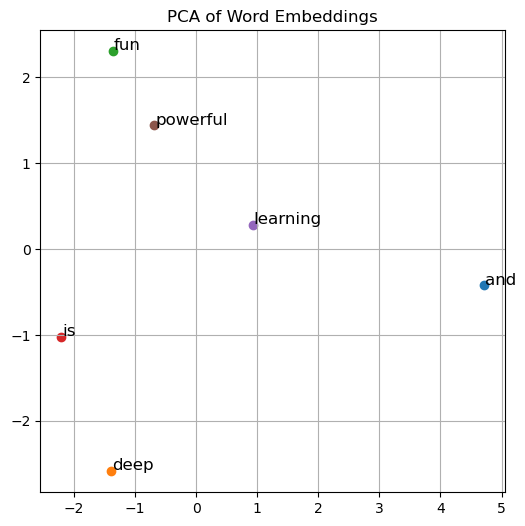

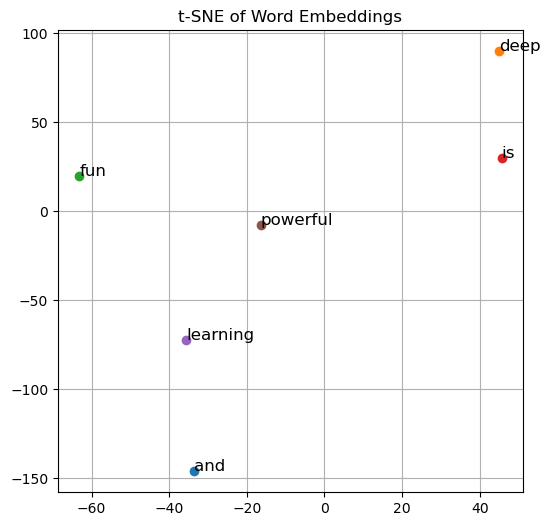

In [18]:
# Extract embeddings

embeddings = model.embedding.weight.data.numpy()

# Get only the vocab-related ones (our vocab_size)

embeddings = embeddings[:len(vocab)]   # shape: [vocab_size, embed_dim]

labels = vocab # Words corresponding to each embedding vector

# PCA

pca = PCA(n_components=2)

pca_result = pca.fit_transform(embeddings)


# t-SNE

tsne = TSNE(n_components=2,perplexity=3, random_state=42)

tsne_result = tsne.fit_transform(embeddings)


# Plotting function

def plot_embeddings(reduced_embeddings, labels, title):

    plt.figure(figsize=(6,6))

    for i, label in enumerate(labels):

        x,y = reduced_embeddings[i]

        plt.scatter(x, y)

        plt.text(x + 0.01, y + 0.01, label, fontsize = 12)

    plt.title(title)

    plt.grid(True)

    plt.show()


# Plot both

plot_embeddings(pca_result, labels, "PCA of Word Embeddings")
plot_embeddings(tsne_result, labels, "t-SNE of Word Embeddings")